# Notebook is to get the beta fits correctly for distributions

- https://stackoverflow.com/questions/54512531/why-doesnt-beta-fit-come-out-right
- https://stackoverflow.com/questions/23329331/how-to-properly-fit-a-beta-distribution-in-python  
- https://stats.stackexchange.com/questions/414277/fitting-beta-distributions-to-data 

In [84]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import fmin
from scipy.stats import beta
from scipy.special import gamma as gammaf
import scipy
from sklearn.neighbors import KernelDensity

In [2]:
#### Functions
def OLS(df, geog, col, alpha):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography
    
    
    Args:
        df = HI stats dataframe
        geog = subset geography to calc people days regression
        col = col to regress on 
        alpha = ci alpha for coef 
    """

    # Get results
    labels = []
    #delt_list = [] #CPT 2020.02.26
    #r2_list = [] #CPT 2020.02.26
    coef_list = []
    leftci_list = []
    rightci_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[col].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        #r2 = model.rsquared_adj #CPT 2020.02.26
        p = model.pvalues[0]

        # Pop change #CPT 2020.02.26
#         delt = df_geog.drop_duplicates('ID_HDC_G0').copy()
#         delt['delt_pop'] = delt['P2016'] - delt['P1983']
#         delt = delt['delt_pop'].sum()

        # GET Left and Right CI
        left_ci = model.conf_int(alpha=alpha)[1][0]
        right_ci = model.conf_int(alpha=alpha)[1][1]
        
        # Make lists
        labels.append(label)
        #r2_list.append(r2) #CPT 2020.02.26
        coef_list.append(coef)
        p_list.append(p)
        leftci_list.append(left_ci)
        rightci_list.append(right_ci)
        #delt_list.append(delt) #CPT 2020.02.26

    # Make data frame
    df_out[geog] = labels
    #df_out['p_delt'] = delt_list #CPT 2020.02.26
    #df_out['r2'] = r2_list #CPT 2020.02.26
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]
    df_out['ci_left'] = leftci_list
    df_out['ci_right'] = rightci_list 

    return df_out

In [3]:
def run_OLS(stats, geog, alpha, p_value):
    """ Function calculate OLS coef of people days due to pop and heat and the 
    attribution index for distribution plots
    
    Args:
        stats = df to feed in
        geog = geography level to conduct analysis (city-level is 'ID-HDC-G0')
        alpha = alpha for CI coef 
        p_value = p_value to drop out coefs
    
    """
    # Get coef for people days
    out = OLS(stats, geog, 'people_days', alpha = alpha)
    out.rename(columns={"coef": "coef_pdays"}, inplace = True)
    out.rename(columns={"p_value": "p_value_pdays"}, inplace = True)
    out.rename(columns={"ci_left": "ci_left_pdays"}, inplace = True)
    out.rename(columns={"ci_right": "ci_right_pdays"}, inplace = True)
    
    # Get people days due to heat coef
    heat = OLS(stats, geog, 'people_days_heat', alpha = alpha) # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    heat.rename(columns={"p_value": "p_value_heat"}, inplace = True)
    heat.rename(columns={"ci_left": "ci_left_heat"}, inplace = True)
    heat.rename(columns={"ci_right": "ci_right_heat"}, inplace = True)
    out = out.merge(heat, on = geog, how = 'left') # merge
    
    # Get people days due to pop
    pop = OLS(stats, geog, 'people_days_pop', alpha = alpha) # get stats 
    pop.rename(columns={"coef": "coef_pop"}, inplace = True)
    pop.rename(columns={"p_value": "p_value_pop"}, inplace = True)
    pop.rename(columns={"ci_left": "ci_left_pop"}, inplace = True)
    pop.rename(columns={"ci_right": "ci_right_pop"}, inplace = True)
    out = out.merge(pop, on = geog, how = 'left') # merge
    
    # Get total days
    totDays = OLS(stats, geog, 'total_days', alpha = alpha) # get stats 
    totDays.rename(columns={"coef": "coef_totDays"}, inplace = True)
    totDays.rename(columns={"p_value": "p_value_totDays"}, inplace = True)
    totDays.rename(columns={"ci_left": "ci_left_totDays"}, inplace = True)
    totDays.rename(columns={"ci_right": "ci_right_totDays"}, inplace = True)
    out = out.merge(totDays, on = geog, how = 'left') # merge
    
    # drop all neg or zero pday slopes
    out = out[out['coef_pdays'] > 0]
    out = out[out['coef_heat'] > 0]
    out = out[out['coef_pop'] > 0]
    out = out[out['coef_totDays'] > 0]
    
    # drop out P_values only for p-days ... idea is where is exposure increasing sig. 
    out = out[out['p_value_pdays'] < p_value]

    # attrib coef --- creates range -1 to 1 index of heat vs. population as a driver of total pdays increase
    out['coef_attrib'] = (out['coef_pop'] - out['coef_heat']) / (out['coef_pop'] + out['coef_heat']) # normalize dif
    
    # I am not sure if this works correcetly ... CPT 2020.02.27
    out['coef_attrib_left'] = (out['ci_left_pop'] - out['ci_left_heat']) / (out['ci_left_pop'] + out['ci_left_heat']) # normalize dif
    out['coef_attrib_right'] = (out['ci_right_pop'] - out['ci_right_heat']) / (out['ci_right_pop'] + out['ci_left_heat']) # normalize dif
    
    # normalize coef of attribution 
    norm = out['coef_attrib']
    out['coef_attrib_norm'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_left']
    out['coef_attrib_norm_left'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_right']
    out['coef_attrib_norm_right'] = (norm-min(norm))/(max(norm)-min(norm))
    
    return out

In [4]:
def beta_fit(data):
    
    """Function fits a beta distribution curve basde on these using scipy beta.fit
    https://stackoverflow.com/questions/23329331/how-to-properly-fit-a-beta-distribution-in-python
    https://stats.stackexchange.com/questions/414277/fitting-beta-distributions-to-data
    
    Args: Normalized data that we want to put together 
    """
 
    #### Fit Data
    alpha3,beta3,xx,yy=beta.fit(data, loc = 0, scale = 1)
    fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

    xx=np.linspace(0,max(data),len(data)) # line space of X
    xx = xx[1:] # drop first value of zero because it makes plot look funky
    yy = fitted(xx,alpha3,beta3) # fit values to beta pdf function
    
    return xx, yy

# Load Data

In [5]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_IN = 'processed/All_data_HI406_figdata.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# scale the date in the plot 
scale = 10**9 

# cols we want to add to HI_STATS
cols = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0'] 

# open all the data
meta_fn = 'processed/All_data_HI406_meta.csv' # open all the data
all_data = pd.read_csv(DATA_IN+meta_fn)

# drop ID duplicates
meta = all_data.drop_duplicates('ID_HDC_G0')
meta = meta[cols]

# Add in geography we may want to use
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'inner')


# Try Beta Fit

In [73]:
#### Chunk the data
geog = 'sub-region'
loc = 'Western Asia'##>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> WHY 'Western Asia'
chunk = HI_STATS[HI_STATS[geog] == loc]
plotdata = run_OLS(chunk, 'ID_HDC_G0', alpha = 0.05, p_value =0.05)

In [74]:
plotdata.shape

(653, 23)

In [75]:
### set lims
ylim = [0,5]
xlim = [0,1]

In [76]:
data = plotdata['coef_attrib_norm']

In [82]:
mean=np.mean(data[data<.9])
var=np.var(data[data<.9],ddof=1)
a=mean**2*(1-mean)/var-mean
b=a*(1-mean)/mean
#a,b,xx,yy=beta.fit(data, loc=0, scale=1)
print(a)
print(b)

3.9232006042780867
1.9739448418694863


(0, 5)

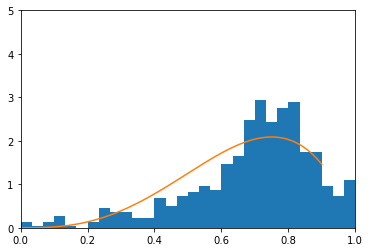

In [83]:
# plot using the pdf in scipy
xx = np.linspace(0,max(data[data<.9]),len(data[data<.9])) # line space of X
yy = beta.pdf(xx, a, b, loc=0, scale=1)

plt.hist(data[data<1], density = True, bins = 30)
plt.plot(xx, yy)
plt.xlim(xlim)
plt.ylim(ylim)

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 5)

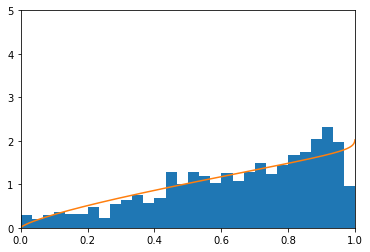

In [13]:
# using manu calc of beta function

fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta
xx1 = np.linspace(0,max(data),len(data)) # line space of X
yy1 = fitted(xx1, a, b)
plt.hist(data, density = True, bins = 30)
plt.plot(xx1, yy1)
plt.xlim(xlim)
plt.ylim(ylim)

# TRY MOMENTS

In [14]:
data = plotdata['coef_attrib_norm']

In [15]:
# https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance

mean=np.mean(data)
var=np.var(data,ddof=1)
a=mean**2*(1-mean)/var-mean
b=a*(1-mean)/mean
print('alpha', a)
print('beta', b)

alpha 1.8083115084042714
beta 0.9663136726095257


In [18]:
xx = np.linspace(0,max(data),len(data)) # line space of X

In [41]:
# Get R-2

y, x = np.histogram(data, bins=20, density=True)

# Step 2. Shift the x bin locations to the center of bins.
x = (x + np.roll(x, -1))[:-1] / 2.0

# Step 3. Calculate the values of pdx(x) for all x.
pdf = beta.pdf(x, a, b)

# Step 4. Determine the residual and total sum of the squares.
ss_error = np.sum(np.power(y - pdf, 2.0))
ss_yy = np.sum(np.power(y - y.mean(), 2.0))

r_2 = 1 - ( ss_error / ss_yy )

In [63]:
print(r_2)
scipy.stats.kstest(data, 'beta', args=(a,b))

0.8346985587220603


KstestResult(statistic=0.039866403615296475, pvalue=0.10159584990909856)

(array([0.13782542, 0.04594181, 0.13782542, 0.27565084, 0.04594181,
        0.        , 0.13782542, 0.45941807, 0.36753446, 0.36753446,
        0.22970904, 0.22970904, 0.68912711, 0.50535988, 0.73506891,
        0.82695253, 0.96477795, 0.87289433, 1.47013783, 1.65390505,
        2.48085758, 2.94027565, 2.43491577, 2.75650842, 2.89433384,
        1.74578867, 1.74578867, 0.96477795, 0.73506891, 1.14854518]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

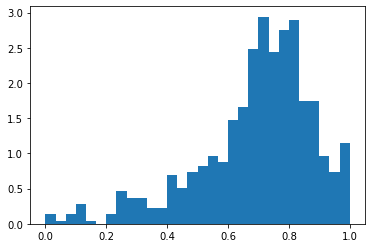

In [88]:
yy = beta.pdf(x, a, b, loc=0, scale=1)
plt.hist(data, density = True, bins = 30)
# plt.plot(xx, yy)
# plt.xlim(xlim)
# plt.ylim(ylim)

In [87]:
data

0      0.543710
1      0.734241
2      0.605655
3      0.085903
4      0.777699
         ...   
713    0.707129
714    0.780105
715    0.586598
716    0.590286
717    0.735076
Name: coef_attrib_norm, Length: 653, dtype: float64

In [106]:
y = [0.13782542, 0.04594181, 0.13782542, 0.27565084, 0.04594181,
        0.        , 0.13782542, 0.45941807, 0.36753446, 0.36753446,
        0.22970904, 0.22970904, 0.68912711, 0.50535988, 0.73506891,
        0.82695253, 0.96477795, 0.87289433, 1.47013783, 1.65390505,
        2.48085758, 2.94027565, 2.43491577, 2.75650842, 2.89433384,
        1.74578867, 1.74578867, 0.96477795, 0.73506891, 1.14854518]
x = [0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]

In [98]:
len(y)

31

In [99]:
arr = np.vstack((x, y[1:])).T

In [100]:
arr

array([[0.13782542, 0.03333333],
       [0.04594181, 0.06666667],
       [0.13782542, 0.1       ],
       [0.27565084, 0.13333333],
       [0.04594181, 0.16666667],
       [0.        , 0.2       ],
       [0.13782542, 0.23333333],
       [0.45941807, 0.26666667],
       [0.36753446, 0.3       ],
       [0.36753446, 0.33333333],
       [0.22970904, 0.36666667],
       [0.22970904, 0.4       ],
       [0.68912711, 0.43333333],
       [0.50535988, 0.46666667],
       [0.73506891, 0.5       ],
       [0.82695253, 0.53333333],
       [0.96477795, 0.56666667],
       [0.87289433, 0.6       ],
       [1.47013783, 0.63333333],
       [1.65390505, 0.66666667],
       [2.48085758, 0.7       ],
       [2.94027565, 0.73333333],
       [2.43491577, 0.76666667],
       [2.75650842, 0.8       ],
       [2.89433384, 0.83333333],
       [1.74578867, 0.86666667],
       [1.74578867, 0.9       ],
       [0.96477795, 0.93333333],
       [0.73506891, 0.96666667],
       [1.14854518, 1.        ]])

In [108]:
kde = KernelDensity(kernel='linear', bandwidth=0.2).fit(arr)

In [119]:
Y = kde.score_samples(arr)
X = list(range(0, len(Y)))

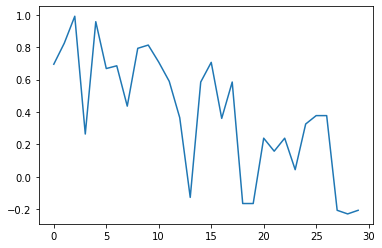

In [120]:
plt.plot(X$,Y)

Text(0.5, 1.0, 'Western Asia')

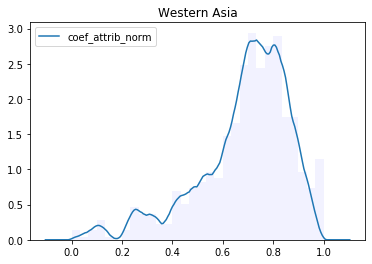

In [143]:
sns.kdeplot(data, kernel = 'cos', clip = [0.03, .97], gridsize = 200)
plt.hist(data, alpha = 0.05, color = 'b', density = True, bins = 30);
plt.title('Western Asia')